In [18]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import EncoderNormalizer, GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)
import warnings


warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [19]:

print(torch.cuda.is_available())  # Should print True if GPU is available
print(torch.cuda.device_count())  # Should print the number of GPUs
print(torch.cuda.get_device_name(0))  # Check GPU model (if available)

False
0


AssertionError: Torch not compiled with CUDA enabled

In [20]:
# Define relative file paths for training and testing data
train_file = "..\\Data\\Train\\trains1990s.csv"

# Load Training Data
train_df = pd.read_csv(train_file, parse_dates=['observation_date'], date_format="%m/%y%")

train_df = train_df.iloc[:,:2]
train_df.set_index('observation_date', inplace=True)
# add time index
train_df["time_idx"] = range(1, len(train_df) + 1)
train_df["group_id"] = 0
train_df


,fred_PCEPI,time_idx,group_id
observation_date,,,
01/1990,58.553,1,0
02/1990,58.811,2,0
03/1990,59.033,3,0
04/1990,59.157,4,0
05/1990,59.290,5,0
...,...,...,...
08/2020,104.887,368,0
09/2020,105.046,369,0
10/2020,105.106,370,0


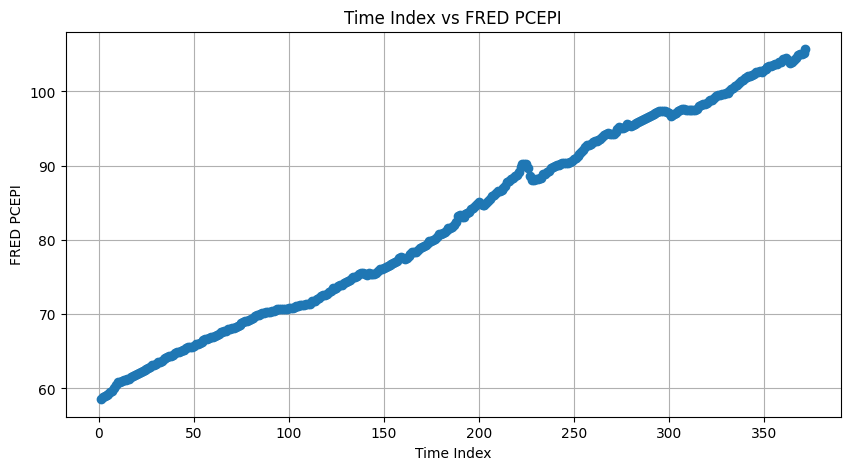

In [21]:
import matplotlib.pyplot as plt

# Plot time_idx vs fred_PCEPI
plt.figure(figsize=(10, 5))
plt.plot(train_df["time_idx"], train_df["fred_PCEPI"], marker='o', linestyle='-')

# Labels and title
plt.xlabel("Time Index")
plt.ylabel("FRED PCEPI")
plt.title("Time Index vs FRED PCEPI")

# Show plot
plt.grid(True)
plt.show()


In [49]:
cuttoff = round(0.8 * len(train_df))
train_sample = train_df[0:cuttoff]
val_sample = train_df[cuttoff:]
min_encoder_length = len(train_df) - cuttoff
cuttoff

298

In [41]:
max_prediction_length = 6
training_cutoff = train_df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    train_sample,
    time_idx="time_idx",
    target="fred_PCEPI",
    group_ids=["group_id"],
    min_encoder_length=min_encoder_length// 2,
    max_encoder_length=cuttoff,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=[
        "fred_PCEPI"
    ],
    target_normalizer=EncoderNormalizer(),
    add_target_scales=True,
    add_encoder_length=True,
)
fullset = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="fred_PCEPI",
    group_ids=["group_id"],
    min_encoder_length=min_encoder_length// 2,
    max_encoder_length=cuttoff,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=[
        "fred_PCEPI"
    ],
    target_normalizer=EncoderNormalizer(),
    add_target_scales=True,
    add_encoder_length=True,
)

In [42]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, train_df, predict=True, stop_randomization=True
)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)
valall = fullset.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [25]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
RMSE()(baseline_predictions.output, baseline_predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(0.9190)

In [26]:
# configure network and trainer
pl.seed_everything(42)
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=RMSE(),
    optimizer="adam",
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 5.9k


In [27]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 80     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 718    | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 320    | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 304    | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304    

Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s, v_num=14, train_loss_step=0.478, val_loss=0.315, train_loss_epoch=0.526]


In [28]:
trainer.validate(model = tft, dataloaders = val_dataloader)

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_MAE            0.27436700463294983
        val_MAPE           0.0026117207016795874
        val_RMSE            0.31541240215301514
        val_SMAPE          0.0026100389659404755
        val_loss            0.31541240215301514
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.31541240215301514,
  'val_SMAPE': 0.0026100389659404755,
  'val_MAE': 0.27436700463294983,
  'val_RMSE': 0.31541240215301514,
  'val_MAPE': 0.0026117207016795874}]

In [29]:
# calcualte mean absolute error on validation set
predictions = tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
RMSE()(predictions.output, predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


tensor(0.3154)

In [47]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = tft.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)
print(raw_predictions.x.keys)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<built-in method keys of dict object at 0x0000017067795A40>


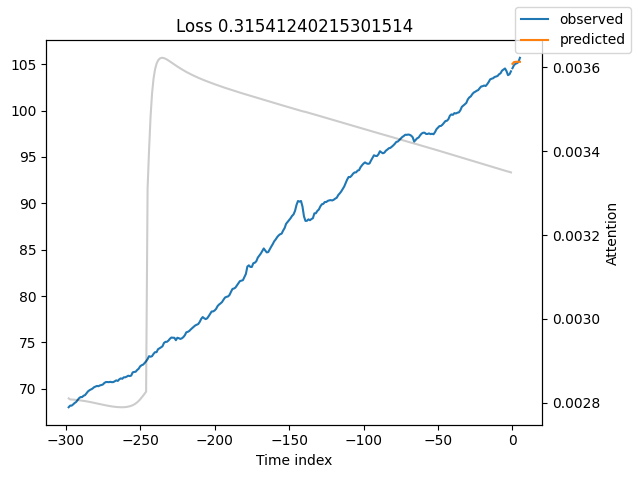

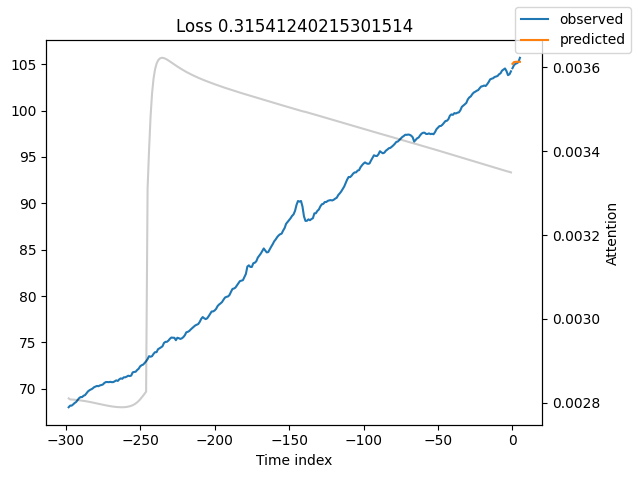

In [48]:

tft.plot_prediction(
    raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True
)